In [91]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from matplotlib.collections import PolyCollection

from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation
import astropy.units as u

from scipy.stats import binned_statistic

%matplotlib inline

In [2]:
gammas = pd.read_hdf('../build/gamma_pointlike.h5', 'array_events')
gammas['az'] = Angle(gammas.az.values *u.deg).wrap_at(360*u.deg).to_value('deg')
gammas['mc_az'] = Angle(gammas.mc_az.values *u.deg).wrap_at(360*u.deg).to_value('deg')

In [3]:
gammas.head()

,alt,alt_uncert,array_event_id,average_intensity,az,az_uncert,core_uncert,core_x,core_y,goodness_of_fit,...,num_triggered_lst,num_triggered_mst,num_triggered_sst,num_triggered_telescopes,run_id,total_intensity,gamma_prediction_mean,gamma_prediction_std,gamma_energy_prediction_mean,gamma_energy_prediction_std
0,70.421106,1.671715,1103,51.264244,180.136704,NaN,NaN,10.419219,-12.107142,NaN,...,7,0,0,7,14,256.321219,0.448488,0.040418,0.144688,0.012583
1,69.789104,0.061116,4107,73.662462,179.362601,NaN,NaN,-366.388877,337.539153,NaN,...,0,3,0,3,14,220.987387,0.592497,0.085257,0.151708,0.002293
2,70.001232,1.098466,4305,269.830409,180.239674,NaN,NaN,-21.941636,58.651585,NaN,...,11,6,0,17,14,4587.116945,0.536264,0.161971,0.303530,0.028251
3,70.038409,0.711043,5705,99.520204,180.561848,NaN,NaN,-108.664938,-139.093148,NaN,...,5,0,0,5,14,497.601020,0.355195,0.076761,0.137415,0.004062
4,70.064735,0.251989,8206,73.652738,180.396178,NaN,NaN,-59.305987,-107.589906,NaN,...,7,0,0,7,14,441.916429,0.530469,0.022007,0.148824,0.023339


In [4]:
gammas[['alt', 'az', 'mc_alt', 'mc_az']].head()

,alt,az,mc_alt,mc_az
0,70.421106,180.136704,70.0,180.000005
1,69.789104,179.362601,70.0,180.000005
2,70.001232,180.239674,70.0,180.000005
3,70.038409,180.561848,70.0,180.000005
4,70.064735,180.396178,70.0,180.000005


#### Debug Plots
Plot some histograms of the difference between true and reconstructed azimuth and altitude seperately.
No normalization of angles takses place. So we see an offset of 360 degree in the azimuth. Not a huge problem imo.

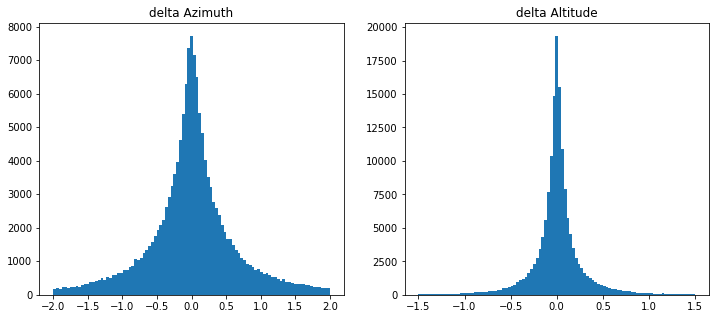

In [5]:
f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(gammas.az - gammas.mc_az, bins=np.linspace(-2, 2, 100))
ax1.set_title('delta Azimuth')
ax2.hist(gammas.alt - gammas.mc_alt, bins=np.linspace(-1.5, 1.5, 100))
ax2.set_title('delta Altitude')
None

Use __astropy__ to calculate the angular separation between the to coordinate pairs. We wrap the raw numbers in an astropy `Angle` object and wrap the values at 180 Deg. Then plot the histograms of the distances and the 68, 95, and 99 percentiles. 

In [6]:
def calculate_distance_to_true_source_position(df):
    source_az = Angle(df.mc_az.values * u.deg).wrap_at(180 * u.deg)
    source_alt = Angle(df.mc_alt.values * u.deg)

    az = Angle(df.az.values*u.deg).wrap_at(180 * u.deg)
    alt = Angle(df.alt.values*u.deg)

    distance = angular_separation(source_az, source_alt, az, alt).to(u.deg)
    return distance

[0.3137177  1.1559532  3.63349419]


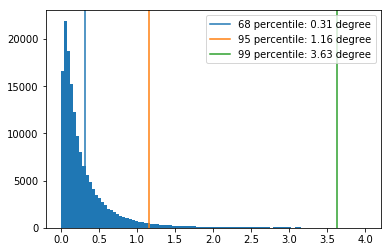

In [7]:
distances = calculate_distance_to_true_source_position(gammas)
plt.hist(distances.value, bins=np.linspace(0, 4, 100))
pvs = [68, 95, 99]
ps = np.nanpercentile(distances.value, pvs)
for i, (p, l) in enumerate(zip(ps, pvs)):
    plt.axvline(x=p, ymax=1000, label=f'{l} percentile: {p:.2f} degree', color=f'C{i}')
print(ps)
plt.legend()
None

Now we plot the histogram vs the true energy `mc_energy` to show the dependency of angular resolution on the energy.

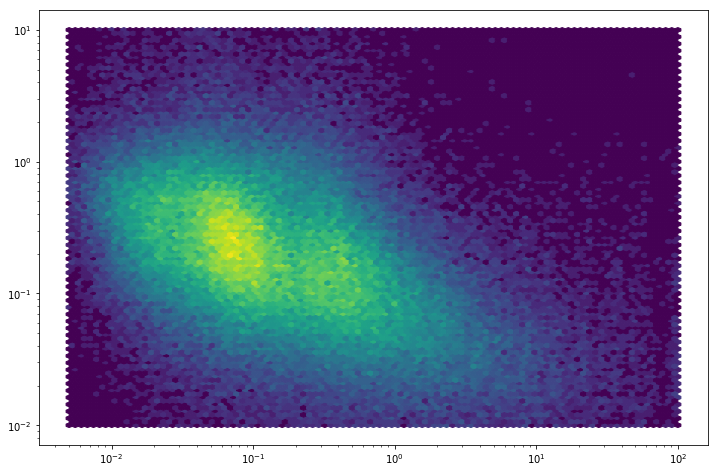

In [8]:
plt.figure(figsize=(12, 8))
plt.hexbin(gammas.mc_energy, distances, xscale='log', yscale='log', extent=(-2.3, 2, -2, 1), norm=PowerNorm(0.5))

## Comparison

Now I compare the processing to the old data processed approx half a year ago. 

In [9]:
import fact.io

gammas_old = fact.io.read_h5py('../data/old_processing/gammas.hdf5', 'array_events')
gammas_old.rename({'alt_prediction': 'alt', 'az_prediction': 'az'}, axis='columns', inplace=True)
cols = ['alt', 'az', 'mc_alt', 'mc_az']
gammas_old[cols] = gammas_old[cols].apply(np.rad2deg)
gammas_old['az'] = Angle(gammas_old.az.values *u.deg).wrap_at(180*u.deg).to_value('deg')
gammas_old['mc_az'] = Angle(gammas_old.mc_az.values *u.deg).wrap_at(180*u.deg).to_value('deg')

In [10]:
gammas_old[cols].head()

,alt,az,mc_alt,mc_az
0,70.009158,-0.075740,70.0,-0.000017
1,70.077979,-0.044806,70.0,-0.000017
2,69.993841,-0.082413,70.0,-0.000017
3,70.040978,-0.397738,70.0,-0.000017
4,70.002388,0.017538,70.0,-0.000017


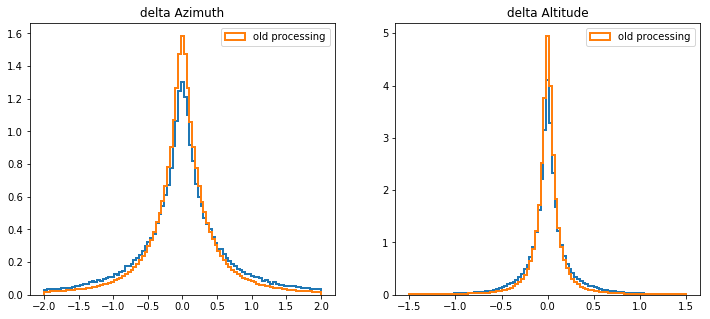

In [11]:
f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(gammas.az - gammas.mc_az, bins=np.linspace(-2, 2, 100), histtype='step', lw=2, density=True)
ax1.hist((gammas_old.az - gammas_old.mc_az), bins=np.linspace(-2, 2, 100), histtype='step', lw=2, label='old processing', density=True)
ax1.set_title('delta Azimuth')
ax1.legend()
ax2.hist(gammas.alt - gammas.mc_alt, bins=np.linspace(-1.5, 1.5, 100), histtype='step', lw=2, density=True)
ax2.hist(gammas_old.alt - gammas_old.mc_alt, bins=np.linspace(-1.5, 1.5, 100), histtype='step', lw=2, label='old processing', density=True)
ax2.legend()
ax2.set_title('delta Altitude')
None

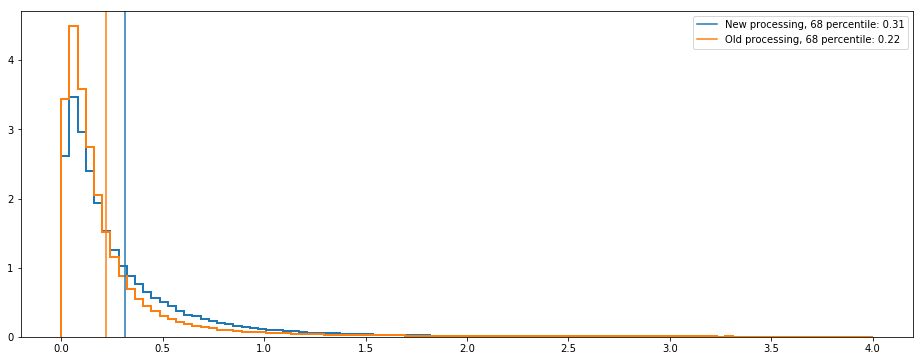

In [92]:
plt.figure(figsize=(16, 6))

distances = calculate_distance_to_true_source_position(gammas)
plt.hist(distances.value, bins=np.linspace(0, 4, 100), histtype='step', lw=2, density=True)
p = np.nanpercentile(distances.value, 68)
plt.axvline(x=p, label=f'New processing, 68 percentile: {p:.2f}', )

distances_old = calculate_distance_to_true_source_position(gammas_old)
plt.hist(distances_old.value, bins=np.linspace(0, 4, 100), histtype='step', lw=2, density=True)
p = np.nanpercentile(distances_old.value, 68)
plt.axvline(x=p, label=f'Old processing, 68 percentile: {p:.2f}', color='C1')


plt.legend()
None

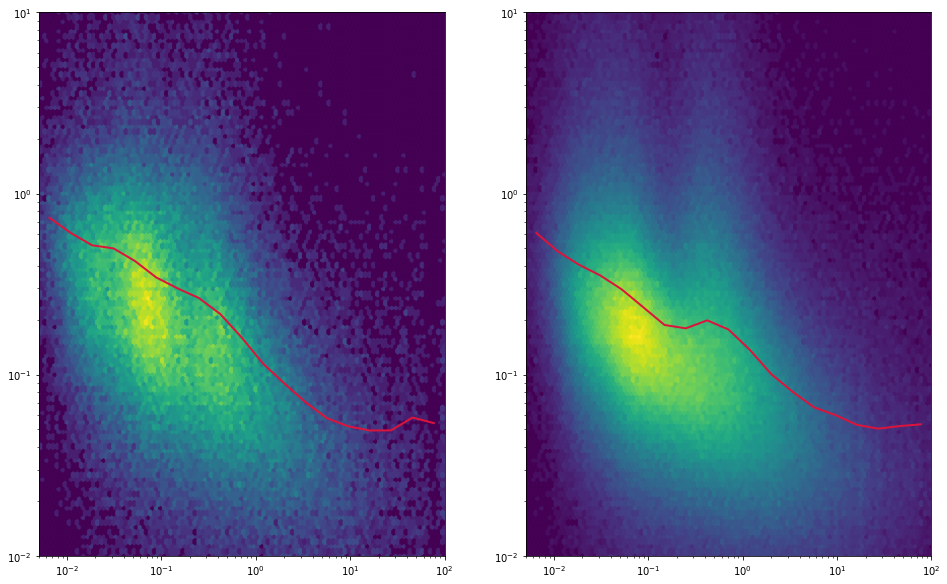

In [13]:

f, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 10))
ax1.hexbin(gammas.mc_energy, distances, xscale='log', yscale='log', extent=(-2.3, 2, -2, 1), norm=PowerNorm(0.5))
ax2.hexbin(gammas_old.mc_energy, distances_old, xscale='log', yscale='log', extent=(-2.3, 2, -2, 1), norm=PowerNorm(0.5))

bins = np.logspace(-2.3, 2, 20)
mask = np.isfinite(distances_old)
b_68_old, bin_edges, binnumber = binned_statistic(gammas_old.mc_energy[mask], distances_old.value[mask], statistic=lambda y: np.percentile(y, 68), bins=bins)
bin_centers = np.sqrt(bins[1:] * bins[:-1])
ax2.plot(bin_centers, b_68_old, lw=2, label='68% Percentile', color='crimson')

mask = np.isfinite(distances)
b_68_new, bin_edges, binnumber = binned_statistic(gammas.mc_energy[mask], distances.value[mask], statistic=lambda y: np.percentile(y, 68), bins=bins)
bin_centers = np.sqrt(bins[1:] * bins[:-1])
ax1.plot(bin_centers, b_68_new, lw=2, label='68% Percentile', color='crimson')

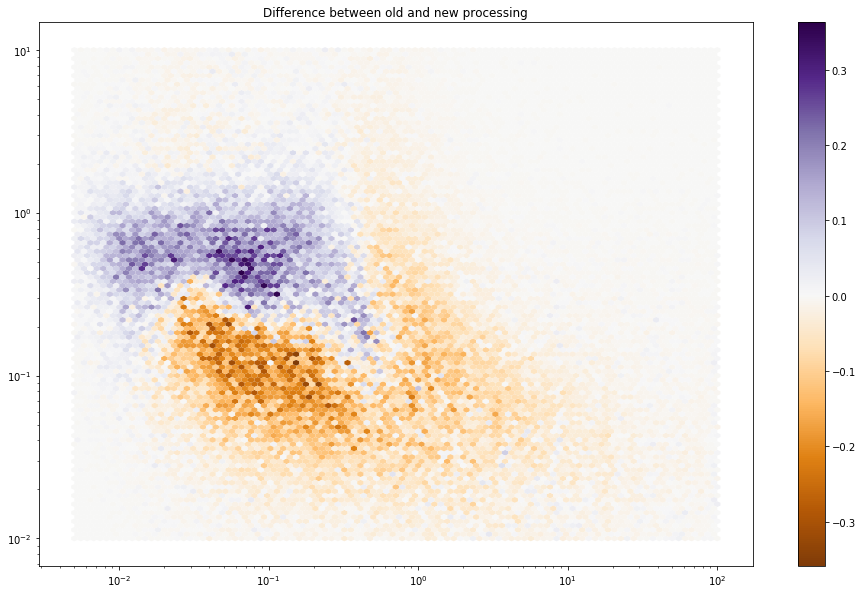

In [94]:

fig = plt.figure()
pc = plt.hexbin(gammas.mc_energy, distances, xscale='log', yscale='log', extent=(-2.3, 2, -2, 1), norm=PowerNorm(0.5))
pc_old = plt.hexbin(gammas_old.mc_energy, distances_old, xscale='log', yscale='log', extent=(-2.3, 2, -2, 1), norm=PowerNorm(0.5))
plt.close(fig)

vs = [p.vertices for p in pc.get_paths()]
diff = pc.get_array()/(pc.get_array().max() - pc.get_array().min()) - pc_old.get_array()/(pc_old.get_array().max() - pc_old.get_array().min())

pc_new = PolyCollection(vs, cmap='PuOr')
pc_new.set_array(diff)

f, ax = plt.subplots(figsize=(16, 10))
ax.add_collection(pc_new)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Difference between old and new processing')
f.colorbar(pc_new)

In [14]:
def load_angular_resolution_requirement(site='paranal'):
    path = '../../cta_performance_plots/cta_plots/resources/ascii/CTA-Performance-prod3b-v1-South-20deg-50h-Angres.txt'
    df = pd.read_csv(path, delimiter='\t\t', skiprows=11, names=['energy', 'resolution'], engine='python')
    return df

def angular_resolution_vs_energy(df):
    
    distances = calculate_distance_to_true_source_position(df)
    mask = np.isfinite(distances)
    
    bins = np.logspace(-2.3, 2, 20)
    bin_centers = np.sqrt(bins[1:] * bins[:-1])
    
    b_68, bin_edges, binnumber = binned_statistic(df.mc_energy[mask], distances.value[mask], statistic=lambda y: np.percentile(y, 68), bins=bins)
    return b_68, bin_edges, bin_centers

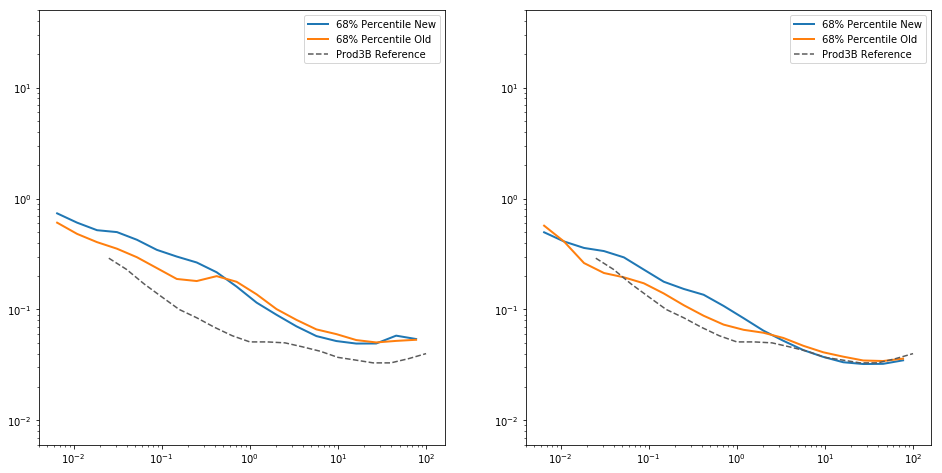

In [90]:
f, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

b_68, _, bin_centers = angular_resolution_vs_energy(gammas)
ax1.plot(bin_centers, b_68, lw=2, label='68% Percentile New', )
b_68, _, bin_centers = angular_resolution_vs_energy(gammas_old)
ax1.plot(bin_centers, b_68, lw=2, label='68% Percentile Old', )

df = load_angular_resolution_requirement()
ax1.plot(df.energy, df.resolution, '--', color='#5b5b5b', label='Prod3B Reference')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([0.006, 50])
ax1.legend()

multiplicity = 5
b_68, _, bin_centers = angular_resolution_vs_energy(gammas.query(f'num_triggered_telescopes >= {multiplicity}'))
ax2.plot(bin_centers, b_68, lw=2, label='68% Percentile New', )
b_68, _, bin_centers = angular_resolution_vs_energy(gammas_old.query(f'num_triggered_telescopes >= {multiplicity}'))
ax2.plot(bin_centers, b_68, lw=2, label='68% Percentile Old', )

df = load_angular_resolution_requirement()
ax2.plot(df.energy, df.resolution, '--', color='#5b5b5b', label='Prod3B Reference')

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim([0.006, 50])
ax2.legend()